In [1]:
import sys, os, pygmt, importlib
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox         import SeaIceToolbox, SeaIceToolboxManager
import numpy                 as np
import pandas                as pd
import xarray                as xr
import xesmf                 as xe
import matplotlib.pyplot     as plt
from matplotlib.colors       import LogNorm
from pathlib                 import Path

In [15]:
# ---- Nominal ice properties ----
rho_i = 900.0      # kg/m^3
h_i   = 1.0        # m
i_mass = rho_i * h_i  # kg/m^2

print(f"i_mass = rho_i * h_i = {i_mass:g} kg m^-2")


i_mass = rho_i * h_i = 900 kg m^-2


In [ ]:
# ---- Parameter ranges (log-spaced) ----
tau_star = np.logspace(np.log10(0.1), np.log10(100.0), 300)  # interpret as Ku in Pa
F2       = np.logspace(np.log10(0.1), np.log10(100.0), 300)

TAU, F2G = np.meshgrid(tau_star, F2)

# Cs(Ku, F2) = Ku / (i_mass * F2)
Cs = TAU / (i_mass * F2G)


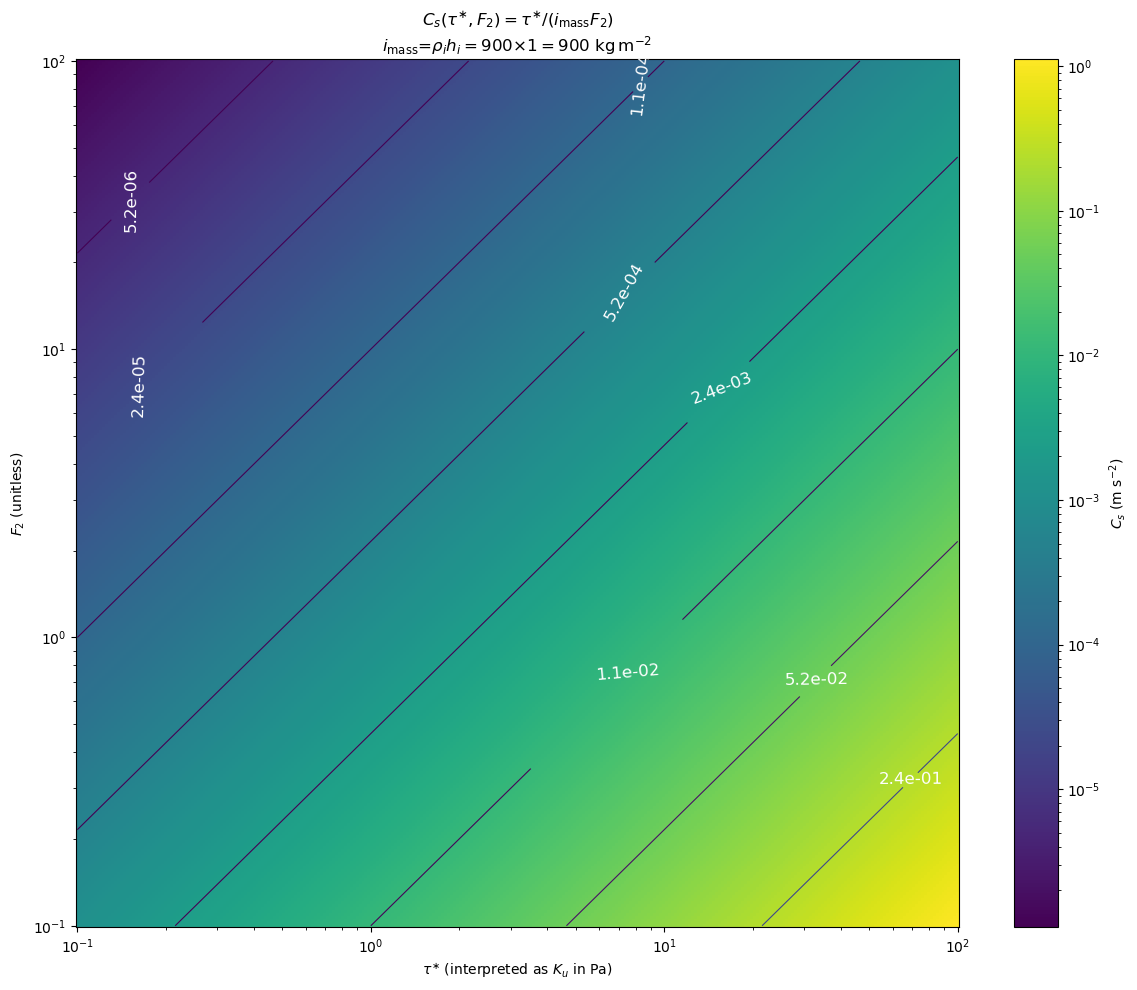

In [22]:

fig, ax = plt.subplots(figsize=(12,10))

pcm = ax.pcolormesh(
    TAU, F2G, Cs,
    shading="auto",
    norm=LogNorm(vmin=Cs.min(), vmax=Cs.max())
)
# Log-spaced contour levels for Cs
levels = np.logspace(np.log10(Cs.min()), np.log10(Cs.max()), 10)
cs_cont = ax.contour(TAU, F2G, Cs, levels=levels, linewidths=0.8)
ax.clabel(cs_cont, inline=True, fontsize=12, fmt="%.1e", colors='white')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\tau^{\ast}$ (interpreted as $K_u$ in Pa)")
ax.set_ylabel(r"$F_2$ (unitless)")
ax.set_title(r"$C_s(\tau^{\ast},F_2)=\tau^{\ast}/(i_{\mathrm{mass}}F_2)$"
             + "\n" + r"$i_{{\mathrm{{mass}}}}$=$\rho_i h_i=$" + f"{rho_i:g}" + r"$\times$" + f"{h_i:g}" + r"$=$" + f"{i_mass:g}" + r"$\ \mathrm{{kg\,m^{{-2}}}}$")

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label(r"$C_s$ (m s$^{-2}$)")

plt.tight_layout()
plt.show()


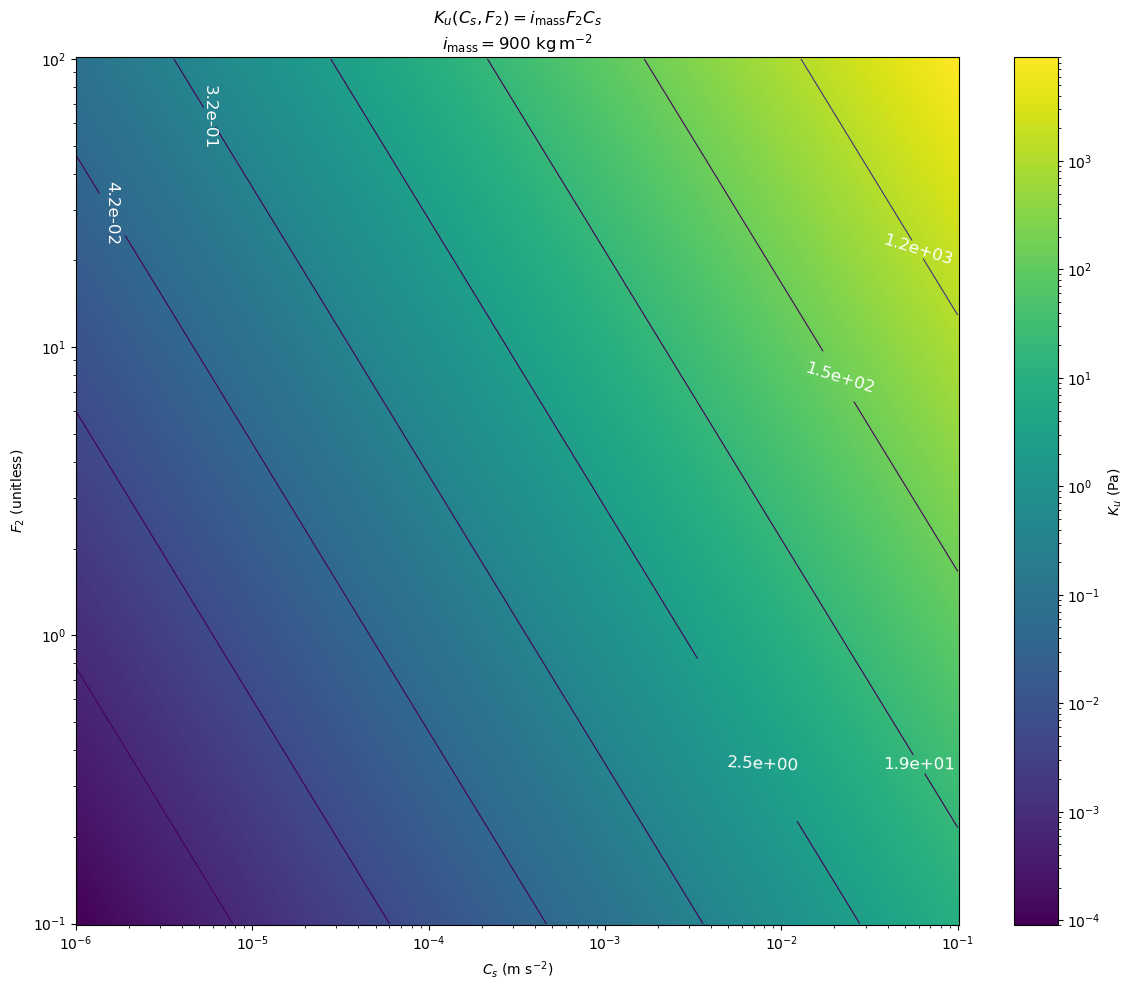

In [21]:
# companion Ku(Cs, F2) map
#
# This is often the more "actionable" tuning view:
# "If I pick Cs and my computed F2 field looks like X, what Ku (Pa) am I applying?"

Cs_grid = np.logspace(-6, -1, 300)     # m s^-2  (adjust range if you like)
F2_grid = np.logspace(-1,  2, 300)     # unitless

CSG, F2G2 = np.meshgrid(Cs_grid, F2_grid)

# Ku = i_mass * F2 * Cs   [Pa]
Ku = i_mass * F2G2 * CSG

fig, ax = plt.subplots(figsize=(12,10))

pcm = ax.pcolormesh(
    CSG, F2G2, Ku,
    shading="auto",
    norm=LogNorm(vmin=Ku.min(), vmax=Ku.max())
)

levels = np.logspace(np.log10(Ku.min()), np.log10(Ku.max()), 10)
ku_cont = ax.contour(CSG, F2G2, Ku, levels=levels, linewidths=0.8)
ax.clabel(ku_cont, inline=True, fontsize=12, fmt="%.1e", colors='white')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$C_s$ (m s$^{-2}$)")
ax.set_ylabel(r"$F_2$ (unitless)")
ax.set_title(
    r"$K_u(C_s,F_2)=i_{\mathrm{mass}}F_2C_s$"
    + "\n"
    + r"$i_{{\mathrm{{mass}}}}=$" + f"{i_mass:g}" + r"$\ \mathrm{{kg\,m^{{-2}}}}$"
)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label(r"$K_u$ (Pa)")

plt.tight_layout()
plt.show()


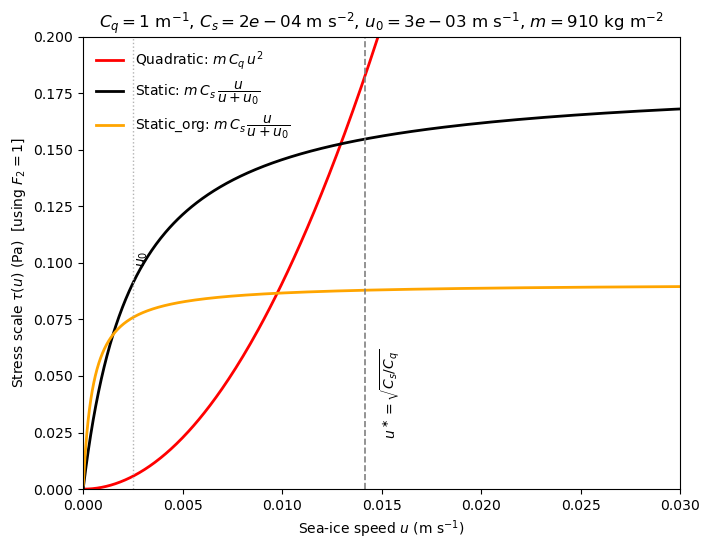

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters from Liu et al. (2022), Fig. 2 + surrounding text ---
Cq = 1.0        # m^-1          (quadratic coefficient)
Cs = 2.0e-4     # m s^-2         (static-friction acceleration scale)
Cs_org = 1.0e-4
u0 = 2.5e-3     # m s^-1         (small velocity in the static-friction form)
u0_org = 5.0e-4
m  = 910.0      # kg m^-2        (rho_i * h for ~1 m ice; used in the paper figure)

# Derived crossover velocity where K1(u) ~ K2(u) ~ Cs (for u >> u0)
u_star = np.sqrt(Cs / Cq)  # ~ 0.01 m/s for the chosen parameters

# --- Speed range (log-spaced) ---
u = np.logspace(-5, -1, 600)  # 1e-5 to 1e-1 m/s covers u0 and u*

# --- Velocity functions (m s^-2) ---
K1 = Cq * u**2                       # quadratic: K1(u) = Cq |u| u (magnitude)
K2 = Cs * (u / (u + u0))             # static friction: K2(u) = Cs * u/(|u|+u0)
K2_org = Cs_org * (u / (u + u0_org))

# --- Convert to a representative stress scale (Pa) using tau = m * K(u) (taking F=1) ---
tau1 = m * K1
tau2 = m * K2
tau_org = m * K2_org

# --- Plot (stress vs speed), matching the usual interpretation of Liu et al. Fig. 2 ---
fig, ax = plt.subplots(figsize=(7.2, 5.6))

#ax.loglog(u, tau1, color="red",  lw=2.0, label=r"Quadratic: $m\,C_q\,u^2$")
ax.plot(u, tau1, color="red",  lw=2.0, label=r"Quadratic: $m\,C_q\,u^2$")
ax.plot(u, tau2, color="black", lw=2.0, label=r"Static: $m\,C_s\,\dfrac{u}{u+u_0}$")
ax.plot(u, tau_org, color="orange", lw=2.0, label=r"Static_org: $m\,C_s\,\dfrac{u}{u+u_0}$")
#ax.loglog(u, tau2, color="black", lw=2.0, label=r"Static: $m\,C_s\,\dfrac{u}{u+u_0}$")

# Reference markers used/mentioned in the paper discussion
ax.axvline(u_star, color="0.5", lw=1.2, ls="--")
ax.text(u_star*1.05, 0.025, r"$u^\ast=\sqrt{C_s/C_q}$", rotation=90,  fontsize=10) #va="bottom",

ax.axvline(u0, color="0.7", lw=1.0, ls=":")
ax.text(u0*1.05, 0.1, r"$u_0$", rotation=90, fontsize=10) #va="bottom",

# Labels + title
ax.set_xlabel(r"Sea-ice speed $u$ (m s$^{-1}$)")
ax.set_ylabel(r"Stress scale $\tau(u)$ (Pa)  [using $F_2=1$]")

ax.set_title(
    # r"Replica of Liu et al. (2022) Fig. 2 concept: quadratic vs static $K(u)$"
    # + "\n"
    # + 
    rf"$C_q={Cq:g}$ m$^{{-1}}$, $C_s={Cs:.0e}$ m s$^{{-2}}$, $u_0={u0:.0e}$ m s$^{{-1}}$, $m={m:g}$ kg m$^{{-2}}$"
)

ax.legend(frameon=False, loc="upper left")
ax.set_ylim(0,0.2)
ax.set_xlim(0,0.03)
#ax.set_yscale("log")
# Optional: show the corresponding acceleration scale on a secondary y-axis
# ax2 = ax.twinx()
# ax2.set_yscale("log")
# ax2.set_ylim(ax.get_ylim()[0]/m, ax.get_ylim()[1]/m)
# ax2.set_ylabel(r"Acceleration scale $K(u)$ (m s$^{-2}$)")

plt.tight_layout()

# Optional save for Sphinx docs
# fig.savefig("../figures/liu2022_fig2_replica.png", dpi=250, bbox_inches="tight")

plt.show()
